

# Character-level language model

In this notebook we train a language model on a small corpus and use it to generate new text in the same style. We are defining the conditional probability of the next character in a sequence given characters up until the current time. To do this we will use an LSTM.

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

# replace with your own root directory
ROOT="/Users/bneepunkumar/"

Convert characters from the text corpus into tokens from a fixed *vocabulary*.  Convert upper case letters to lower case. Characters other than letters, full-stop and space will be omitted (e.g. other punctuation, mumerical digits).  We will then use a one-hot encoding for each token as input to the RNN.

In [9]:
# character encoding: lower case letters, full-stop and space.
chars = 'abcdefghijklmnopqrstuvwxyz. '
input_size = len(chars)  # for one-hot encoding

# define a mapping from char to integer (token index) and vice versa
char_to_int = {}    # ensure the dictionaries are empty
int_to_char = {}
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

def tokenize(data):
    # tokenize text string
    
    # convert to lower case
    data = data.lower()
    
    # integer encode (tokenize) each character; -1 if not in chars, drop these
    idx = torch.tensor([char_to_int.get(char,-1) for char in data], dtype=torch.long)
    idx = idx[idx != -1]  
    return idx

def onehot(idx, input_size):
    # convert to one-hot form (batch_size x sequence_length x input_size).
    # works for any tensor size and adds one-hot encoding of indices as a new dimension at the end
    inputs = torch.eye(input_size,dtype=int)[idx]      
    inputs = inputs.float()
    return inputs


To use the PyTorch data loader facilities, we need to define a new dataset to access the text corpus.

In [10]:
class Alice(Dataset):
    """ Alice in Wonderland custom dataset """
    
    def __init__(self, size):
        # read in the text and tokenize
        f = open('/Users/bneepunkumar/Downloads/alice_in_wonderland.txt')
        data = f.read()
        self.idx = tokenize(data)
        
        self.size = size    # the size of text windows to be used in training

    def __getitem__(self, index):
        """ Returns one data item (token sequence) """
        return self.idx[index:(index+self.size)]
        
    def __len__(self):
        return len(self.idx) - self.size
    
dataset = Alice(50)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
len(train_dataloader.sampler)

137592

Define the network. This is an LSTM followed by a fully connected layer.

In [12]:
class MyRNN(nn.Module):
    def __init__(self, input_size):
        super(MyRNN, self).__init__()
        
        # single LSTM layer, with dropout(0.5)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=128, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(128,input_size)
        
    def forward(self, input, zero_hidden = True):
        if zero_hidden:
            # hidden state defaults to zero
            output, hiddens = self.lstm(input)    
        else:
            # use the hidden state stored from previous invocation
            output, hiddens = self.lstm(input, self.hiddens)    
        
        # update stored hidden state for future invocation
        self.hiddens = hiddens
        
        output = self.dropout(output)
        output = self.linear(output)
        return output
                    
net = MyRNN(input_size) 

for param in net.parameters():
    print(param.shape)

torch.Size([512, 28])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([28, 128])
torch.Size([28])


Train the network. Each window of text is trimmed by one token at the start for input and one token at the end for the target. This trains the network to predict the next character from all previous characters in the window.

`nn.LSTM` will roll-out the LSTM to operate on the given sequence. We don't need to do this explicitly. Likewise, `nn.Linear` operates independently on each time step in the time dimension. 

In [14]:
nepochs = 2
import os
os.makedirs(ROOT+'results/', exist_ok=True)
results_path = ROOT+'results/epochs50hidden128adam.pt'
losses = np.zeros(nepochs)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

net.train()    # to be sure we are in training mode
for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    n = 0
    for i, idx in enumerate(train_dataloader, 0):
        
        inputs = onehot(idx, input_size)
        
        # trim to advance target by one timestep whilst keeping input and target sequences the same length
        inputs = inputs[:,:-1,:]
        targets = idx[:,1:]
        
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = net(inputs)    # initial hidden state will default to zero
        loss = loss_fn(outputs.transpose(1,2), targets)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
       
    losses[epoch] = meanloss = running_loss / n
    print(f"epoch: {epoch+1} loss: {meanloss : .3f}")
    
# save network parameters and losses
torch.save({"state_dict": net.state_dict(), "losses": losses}, results_path)
   

epoch: 1 loss:  1.505
epoch: 2 loss:  1.367


Generate novel text primed by the given prior text.

Run the model repeatedly on the currently generated text, starting with the given prior text.
Select the maximum probability token as the next token in the sequence.

In subsequent runs of the model, only input the most recently selected token since we use the final hidden state and cell state from the previous run to provide the history. 

In [15]:
# restore model parameters and losses
results_path = ROOT+'results/epochs50hidden128adam.pt'
data = torch.load(results_path)
net.load_state_dict(data["state_dict"])

# set prior text
pretext = 'The queen turned to alice'
idx = tokenize(pretext)    # initialise token sequence and generated sequence
gen_length = 400    # length of generated text
output = pretext    # initialise output text

# sample from the network.
zero_hidden = True    # initialise hidden state to zero for the first time through
net.eval()    # set eval mode so that dropout is omitted by the module
with torch.no_grad():    # turn off gradient calculations for the evaluation
    for i in range(gen_length):
        
        inputs = onehot(idx, input_size)
        inputs = torch.unsqueeze(inputs,0) # add batch dimension of size 1: 1 x len(idx) x input_size
        
        outputs = net(inputs, zero_hidden)
        _, predicted = torch.max(outputs, 2)
        
        token = predicted[0,-1].item()    # extract final predicted token as input for next timestep
        output = output + int_to_char[token]       # decode token and append to output
        idx = torch.tensor([token])    # input sequence consisting of a single time step
        zero_hidden = False               # pass on the hidden state in future iterations
          
print(output)   

The queen turned to alice and then the mock turtle and the mock turtle said to herself and she said the king and the mock turtle said to herself and she said the king and the mock turtle said to herself and she said the king and the mock turtle said to herself and she said the king and the mock turtle said to herself and she said the king and the mock turtle said to herself and she said the king and the mock turtle said t


Plot the mean loss after each epoch.

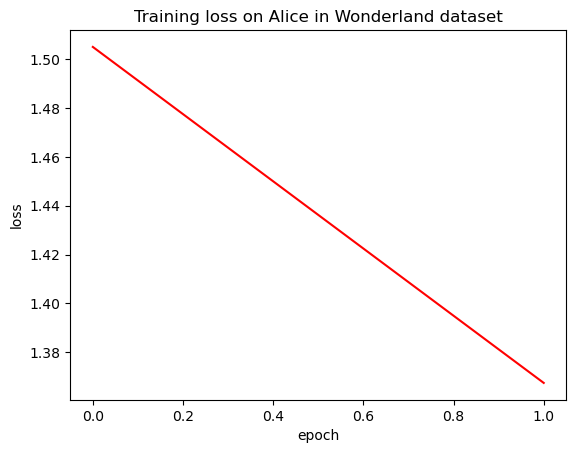

In [16]:
# restore model parameters and losses
results_path = ROOT+'results/epochs50hidden128adam.pt'
data = torch.load(results_path)
losses = data["losses"]

plt.plot(losses, 'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training loss on Alice in Wonderland dataset' )
plt.show()